<a href="https://colab.research.google.com/github/eminamitani/sample_NNP/blob/main/SimpleNNP_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ゼロから始める簡単NNP

Google　Colab用にデータをロードする部分を入れてあります

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## NNPとは？？
Neural Network Potentialの略です。原子構造の情報を受け取って、エネルギーの値を予測する、ニューラルネットワークベースの機械学習モデルです。第一原理計算での構造とエネルギーの関係を再現するように、第一原理計算結果を使って学習させる仕組みを使っています。

この最も単純なケースを試してみましょう。今回扱うのは、結晶Siです。分子動力学法のトラジェクトリーを使って、様々な温度での熱ゆらぎが加わっていたり、密度が異なった状態での1250パターンの構造とエネルギーの情報を集めてあるので、それを学習データにします。

## 対称性関数の計算結果のロード
構造とエネルギーの関係を学ばせるにあたって、まず構造をニューラルネットワーク的に扱いやすいデータに変換する必要があります。
その方法の一つが対称性関数です。

対称性関数の説明や計算は別のファイルにまとめているので、そちらを見てください。
https://github.com/eminamitani/sample_NNP/blob/main/make_desc.ipynb

今回は時間短縮のため保存しておいたデータを使います。

In [ ]:
import numpy as np
desc=np.load('/content/drive/MyDrive/Colab Notebooks/data/desc.npy')
label=np.load('/content/drive/MyDrive/Colab Notebooks/data/label.npy')

In [ ]:
desc.shape

(1250, 64, 11)

データがどんな形か確認してみましょう。descは計算された対称性関数の11の値（最初の値は、G0と表記されるシンプルな動径分布に対応します）を保持していて、labelは系の原子あたりの平均エネルギーの情報を持っています。(全エネルギーそのままだと値が大きすぎるので)

In [ ]:
desc[0,0,:], label[0]

(array([13.571609  ,  9.172703  ,  6.4423614 ,  3.4930756 ,  1.3537661 ,
         0.35307807,  0.03834928,  0.7360559 ,  0.43611127,  0.28210217,
         0.05149077], dtype=float32), -5.8122244)

In [ ]:
desc[1,0,:], label[1]

(array([14.427327  ,  9.910984  ,  7.078461  ,  3.9639223 ,  1.6263943 ,
         0.4749474 ,  0.06694016,  1.0451641 ,  0.593504  ,  0.4443306 ,
         0.08542389], dtype=float32), -5.812823)

対称性関数の値にもそれなりにばらつきがありそうです。

ニューラルネットワークの実装では配列の形を勘違いしてミスをすることが多いので確認しておきます

In [ ]:
desc.shape, label.shape

((1250, 64, 11), (1250,))

本当はデータを正規化したほうが良いのですが、ひとまず単純に処理してみましょう

 ## ニューラルネットワークの定義
 今回は、ニューラルネットワークというと真っ先にイメージされる多層パーセプトロンを使います。

 このモデルでは、11の対称性関数の値を受け取って、それをノード数20の隠れ層に渡し、最終的に一つの出力を得る形になっています。
 この出力は「原子ひとつあたりのエネルギー」に相当すると考えます。原子ひとつあたりのエネルギーが物理的にきちんと定義できるのかはさておき、それらを足し上げると、系の全エネルギーになるようにネットワーク中の重みやバイアスを最適化していきます。

In [ ]:
import torch.nn as nn
import torch
import torch.optim as optim

class Net(nn.Module):
    #n_sf : number of symmetry function
    #two-hidden layer
    #output is energy per atom
    def __init__(self,n_sf,n_hidden):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(n_sf, n_hidden)
        self.a1  = nn.Tanh()
        self.fc2 = nn.Linear(n_hidden, n_hidden)
        self.a2  = nn.Tanh()
        self.fc3 = nn.Linear(n_hidden,1)


        #He initialization
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)
        nn.init.kaiming_normal_(self.fc3.weight)
        self.results={}

        self.layers=[self.fc1, self.a1, self.fc2, self.a2, self.fc3]

    #tahn actination function
    #two hidden layer
    #evaluate eneergy & derivative in forward run
    def forward(self,x):

        for layer in self.layers:
            x=layer(x)

        return x

## 学習データとテストデータの分割
機械学習では過学習（使ったデータにはよく合うが、それ以外のデータにはうまく対応できない）がつきものなので、汎化性能を調べるために、学習データとテストデータの分割を行います。今回は8割を学習データ、2割をテストデータにします。

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(desc, label, test_size=0.2)

pytorchはテンソルを入力として受け取り、出力もテンソルにすることができます。上記の`Net`クラスで実装されているモデルはベクトルを受け取ることを前提にかかれていますが、それが積み上がってテンソルになった入力に対しても柔軟に処理することができます。イメージ的に分かりにくいので、実際にやってみましょう。

In [ ]:
#データ処理の概要確認
#テンソルとしてデータを一気に流し込み、原子数の次元で和を取る
nacsf=11
model=Net(n_sf=nacsf,n_hidden=20)
test_out=model(torch.tensor(X_train))
test_out.shape

torch.Size([1000, 64, 1])

1000データがあって、それぞれに（64,1）の配列が格納されている形式になっています。この64というのは原子数で、実際の正解データと比較するのは、64原子分の総和をとった値です。それは以下のようにして計算できます。

In [ ]:
p_energy=torch.sum(test_out, dim=1)
p_energy.shape


torch.Size([1000, 1])

## データローダーの定義
効率よく学習させるためにはミニバッチ学習が欠かせません。機械学習では、モデルの出力と実際の値の差異のデータを使ってモデル内部のパラメータを更新していくのですが、各データで毎回更新を行っていると時間がかかりますし、学習もなかなか安定しません。なので、データをある程度の塊に分割して、その塊を処理するたびにパラメーター更新をするというような方法を取ります。これがミニバッチ学習です。このとき、毎回同じ塊を取ってくると、学習に偏りが生じてしまうので、塊の取り方も毎回ランダムにするほうが望ましいです。ただそれを実装するのは結構面倒です。pytorchやtensorflowではこういった動作をサポートするためのデータローダーの一式が備わっています。というわけで、そのためのデータローダーを組みます。

torchのtensor型に変換します。y_train, y_testはモデルの出力と整合させるために、unsqueeze(1)で余分な次元をつけています

In [ ]:
X_train=torch.tensor(X_train)
X_test=torch.tensor(X_test)
y_train=torch.tensor(y_train).unsqueeze(1)
y_test=torch.tensor(y_test).unsqueeze(1)

In [ ]:
#define dataset
train_dset=[(data,label) for data, label in zip(X_train, y_train)]
test_dset=[(data,label) for data, label in zip(X_test, y_test)]
nbatch=100
train_loader =torch.utils.data.DataLoader(train_dset, batch_size=nbatch, shuffle=True)
test_loader=torch.utils.data.DataLoader(test_dset, batch_size=nbatch, shuffle=True)

この`train_loader`や`test_loader`はイテレータというものになっています。（要はforループで順番にアクセスできます。）シャッフル済みのデータが取り出せる便利な仕組みと思っておくと良いと思います。

## 学習部分のコード

ログ取得

In [ ]:
from torch.utils.tensorboard import SummaryWriter
import os
import datetime
dir=os.path.join("./logs", datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
writer = SummaryWriter(log_dir=dir)

学習＆テスト結果のループ部分

In [ ]:

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader, test_loader,scheduler):
    for epoch in range(1, n_epochs+1):
        loss_t=0.0
        loss_v=0.0

        #ミニバッチ学習のために順番にアクセスしています
        for train, train_labels in train_loader:
            tmp=model(train)
            p_train=torch.sum(tmp, dim=1)/64.0

            loss_train=loss_fn(p_train, train_labels)

            #パラメータ更新には勾配(微分)をつかうのですが、ほっておくと結果が累積してしまうので、
            #微分を計算する前に初期化します
            optimizer.zero_grad()
            #自動微分で勾配を計算します
            loss_train.backward()

            #パラメータを更新します
            optimizer.step()
            loss_t+=loss_train.item()
        
        #学習率を徐々に下げるスケジューラーというのを使っているので、
        #エポックごとに更新していきます
        scheduler.step()

        #validation
        with torch.no_grad():
            for val, val_labels in test_loader:
                p_val= torch.sum(model(val),dim=1)/64.0
                loss_val=loss_fn(p_val, val_labels)
                loss_v+=loss_val.item()
        
        writer.add_scalar("loss_train", loss_t/len(train_loader), epoch)  
        writer.add_scalar("loss_val", loss_v/len(test_loader), epoch)  
        
        if epoch == 1 or epoch %100 ==0:
            print('Epoch %d, Training Loss %f' %(epoch, loss_t/len(train_loader)))
            print('\t Validation Loss %f' %(loss_v/len(test_loader)))
    
    writer.close()
    return 

パラメータの更新はAdamで行います

In [ ]:
optimizer=optim.Adam(model.parameters(), lr=0.001)
from torch.optim.lr_scheduler import MultiStepLR
scheduler = MultiStepLR(optimizer, milestones=[2000,3000],gamma=0.5)

In [ ]:
training_loop(n_epochs=8000, optimizer=optimizer,model=model,
             loss_fn=nn.MSELoss(), train_loader=train_loader, test_loader=test_loader,scheduler=scheduler)

Epoch 1, Training Loss 33.626525
	 Validation Loss 29.905023
Epoch 100, Training Loss 0.003746
	 Validation Loss 0.003783
Epoch 200, Training Loss 0.003735
	 Validation Loss 0.003748
Epoch 300, Training Loss 0.003709
	 Validation Loss 0.003854
Epoch 400, Training Loss 0.003663
	 Validation Loss 0.003787
Epoch 500, Training Loss 0.003629
	 Validation Loss 0.003795
Epoch 600, Training Loss 0.003612
	 Validation Loss 0.003718
Epoch 700, Training Loss 0.003700
	 Validation Loss 0.003524
Epoch 800, Training Loss 0.003585
	 Validation Loss 0.003691
Epoch 900, Training Loss 0.003495
	 Validation Loss 0.003331
Epoch 1000, Training Loss 0.003496
	 Validation Loss 0.003488
Epoch 1100, Training Loss 0.003517
	 Validation Loss 0.003196
Epoch 1200, Training Loss 0.002450
	 Validation Loss 0.002438
Epoch 1300, Training Loss 0.002041
	 Validation Loss 0.001871
Epoch 1400, Training Loss 0.001882
	 Validation Loss 0.001879
Epoch 1500, Training Loss 0.001290
	 Validation Loss 0.001339
Epoch 1600, Traini

正解と予測結果をプロットしてみましょう

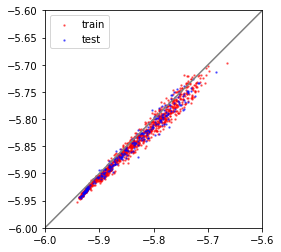

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
model.eval()
with torch.no_grad():
    predict=torch.sum(model(X_test),dim=1)/64.0
    train=torch.sum(model(X_train),dim=1)/64.0
    plt.gca().set_aspect('equal')
    min=-6
    max=-5.6
    plt.xlim((min,max))
    plt.ylim((min,max))
    plt.plot([min,max],[min,max],color='gray')
    
    plt.scatter(y_train,train,c='red',s=2,alpha=0.5,label='train')
    plt.scatter(y_test,predict,c='blue',s=2,alpha=0.5,label='test')
    plt.legend()

In [ ]:
diff=(y_test-predict.to('cpu').detach().numpy()).numpy()
RMSE=np.sqrt(np.mean(np.abs(diff)*np.abs(diff)))
print('RMSE={0:f} eV/atom'.format(RMSE))

RMSE=0.012872 eV/atom


そこまで外れてはいませんが、もうちょい精度が欲しいという感じですね。
精度を上げるには、一つにはデータ数を増やすこと、もう一つは対称性関数のハイパーパラメータを調整したり数を増やすこと、あと、学習でのハイパーパラメータを調整することが挙げられます。
